In [33]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
import speech_recognition as speech_r

DATA_AUDIO_DIR = '../test_train_data'
DATA_ADJUSTED_AUDIO_DIR = '../adjusted_train_data'

list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

r = speech_r.Recognizer() 

OUTPUT_DIR = '../output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')
OUTPUT_DIR_ADJUSTED_TRAIN = os.path.join(OUTPUT_DIR, 'adjusted_train')
OUTPUT_DIR_ADJUSTED_TEST = os.path.join(OUTPUT_DIR, 'adjusted_test')


PAD_SIZE = 10000
TARGET_SR = 8000
AUDIO_LENGTH = TARGET_SR * 10
SEGMENT_NUM = 2

In [34]:
def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

### Delete pickle file & Make directory

In [12]:
del_folder(OUTPUT_DIR_TRAIN)
del_folder(OUTPUT_DIR_TEST)
mkdir_p(OUTPUT_DIR_TRAIN)
mkdir_p(OUTPUT_DIR_TEST)

In [47]:
del_folder(OUTPUT_DIR_ADJUSTED_TRAIN)
del_folder(OUTPUT_DIR_ADJUSTED_TEST)
mkdir_p(OUTPUT_DIR_ADJUSTED_TRAIN)
mkdir_p(OUTPUT_DIR_ADJUSTED_TEST)

In [42]:
del_folder(DATA_ADJUSTED_AUDIO_DIR)
mkdir_p(DATA_ADJUSTED_AUDIO_DIR)

In [43]:
def adjusting_noise():
     for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_DIR, '**/**.wav'), recursive=True)):
        jackhammer = speech_r.AudioFile(wav_filename)

        with jackhammer as source:
            r.adjust_for_ambient_noise(source)
            audio = r.record(source)
            
            output_folder = DATA_ADJUSTED_AUDIO_DIR
            if not os.path.exists(os.path.join(DATA_ADJUSTED_AUDIO_DIR, wav_filename.split('/')[2])):
                mkdir_p(os.path.join(DATA_ADJUSTED_AUDIO_DIR, wav_filename.split('/')[2]))
            output_filename = os.path.join(DATA_ADJUSTED_AUDIO_DIR, wav_filename.split('/')[2], wav_filename.split('/')[3])
            
            fw = open(output_filename, "wb")
            fw.write(audio.get_wav_data())
            fw.close()

In [44]:
adjusting_noise()

In [48]:
order = 0
list_dir.sort()
class_ids = {list_dir[i]: i for i in range(len(list_dir))}

def extract_class_id(wav_filename):
    return class_ids.get(wav_filename.split('/')[2])

def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=TARGET_SR, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():

    for i, wav_filename in enumerate(iglob(os.path.join(DATA_ADJUSTED_AUDIO_DIR, '**/**.wav'), recursive=True)):
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        
        voice_seg = []
        if original_length > AUDIO_LENGTH * SEGMENT_NUM + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            second_seg = audio_buf[AUDIO_LENGTH+PAD_SIZE+1 : PAD_SIZE+AUDIO_LENGTH*2+1]
            
            voice_seg.append(first_seg)
            voice_seg.append(second_seg)
            print(len(first_seg),len(second_seg))
        elif original_length > AUDIO_LENGTH + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            voice_seg.append(first_seg)
            print('Drop 1 Segment, Audio length={}'.format(len(audio_buf)))
        else:
            print('Drop 2 Segment, Audio length={}'.format(len(audio_buf)))
            

        output_folder = OUTPUT_DIR_ADJUSTED_TRAIN
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_ADJUSTED_TEST
            
        output_filename = os.path.join(output_folder, str(wav_filename[23:-4]).replace('/', '_') + '.pkl')
        out_segs = []
        for i_seg, audio_seg in enumerate(voice_seg) :
            out = {'class_id': class_id,
               'audio': audio_seg,
               'sr': TARGET_SR}
            
            with open(str(output_filename+"_"+str(i_seg)), 'wb') as w:
                pickle.dump(out, w)

            print(str(output_filename+"_"+str(i_seg)))
        
        print("-----------------")
      

### Convert Data

In [49]:
convert_data()

0 ../adjusted_train_data/2017019770032_kimdayeong/5.wav 276822 -0.0 0.99999994
80000 80000
../output/adjusted_test/2017019770032_kimdayeong_5.pkl_0
../output/adjusted_test/2017019770032_kimdayeong_5.pkl_1
-----------------
1 ../adjusted_train_data/2017019770032_kimdayeong/1.wav 283648 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019770032_kimdayeong_1.pkl_0
../output/adjusted_train/2017019770032_kimdayeong_1.pkl_1
-----------------
2 ../adjusted_train_data/2017019770032_kimdayeong/3.wav 266923 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019770032_kimdayeong_3.pkl_0
../output/adjusted_train/2017019770032_kimdayeong_3.pkl_1
-----------------
3 ../adjusted_train_data/2017019770032_kimdayeong/2.wav 255659 0.0 1.0000001
80000 80000
../output/adjusted_train/2017019770032_kimdayeong_2.pkl_0
../output/adjusted_train/2017019770032_kimdayeong_2.pkl_1
-----------------
4 ../adjusted_train_data/2017019770032_kimdayeong/4.wav 262998 0.0 0.99999994
80000 80000
../output/adjust

37 ../adjusted_train_data/2017019880004_myeongjaewon/3.wav 180930 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880004_myeongjaewon_3.pkl_0
../output/adjusted_train/2017019880004_myeongjaewon_3.pkl_1
-----------------
38 ../adjusted_train_data/2017019880004_myeongjaewon/2.wav 188547 -0.0 0.9999999
80000 80000
../output/adjusted_train/2017019880004_myeongjaewon_2.pkl_0
../output/adjusted_train/2017019880004_myeongjaewon_2.pkl_1
-----------------
39 ../adjusted_train_data/2017019880004_myeongjaewon/4.wav 189847 -0.0 0.9999999
80000 80000
../output/adjusted_train/2017019880004_myeongjaewon_4.pkl_0
../output/adjusted_train/2017019880004_myeongjaewon_4.pkl_1
-----------------
40 ../adjusted_train_data/2017019770029_jueunhong/5.wav 247979 0.0 1.0
80000 80000
../output/adjusted_test/2017019770029_jueunhong_5.pkl_0
../output/adjusted_test/2017019770029_jueunhong_5.pkl_1
-----------------
41 ../adjusted_train_data/2017019770029_jueunhong/1.wav 252075 -0.0 1.0
80000 80000
../output/adjust

75 ../adjusted_train_data/2017019880027_leesol/5.wav 204336 0.0 1.0
80000 80000
../output/adjusted_test/2017019880027_leesol_5.pkl_0
../output/adjusted_test/2017019880027_leesol_5.pkl_1
-----------------
76 ../adjusted_train_data/2017019880027_leesol/1.wav 198763 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880027_leesol_1.pkl_0
../output/adjusted_train/2017019880027_leesol_1.pkl_1
-----------------
77 ../adjusted_train_data/2017019880027_leesol/3.wav 199692 0.0 1.0
80000 80000
../output/adjusted_train/2017019880027_leesol_3.pkl_0
../output/adjusted_train/2017019880027_leesol_3.pkl_1
-----------------
78 ../adjusted_train_data/2017019880027_leesol/2.wav 207122 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880027_leesol_2.pkl_0
../output/adjusted_train/2017019880027_leesol_2.pkl_1
-----------------
79 ../adjusted_train_data/2017019880027_leesol/4.wav 201921 -0.0 0.9999998
80000 80000
../output/adjusted_train/2017019880027_leesol_4.pkl_0
../output/adjusted_train/2017019880

113 ../adjusted_train_data/2017019740002_kimjiho/2.wav 206507 0.0 0.9999999
80000 80000
../output/adjusted_train/2017019740002_kimjiho_2.pkl_0
../output/adjusted_train/2017019740002_kimjiho_2.pkl_1
-----------------
114 ../adjusted_train_data/2017019740002_kimjiho/4.wav 205142 0.0 1.0
80000 80000
../output/adjusted_train/2017019740002_kimjiho_4.pkl_0
../output/adjusted_train/2017019740002_kimjiho_4.pkl_1
-----------------
115 ../adjusted_train_data/2017019880008_jangsoojin/5.wav 220126 -0.0 1.0
80000 80000
../output/adjusted_test/2017019880008_jangsoojin_5.pkl_0
../output/adjusted_test/2017019880008_jangsoojin_5.pkl_1
-----------------
116 ../adjusted_train_data/2017019880008_jangsoojin/1.wav 227928 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880008_jangsoojin_1.pkl_0
../output/adjusted_train/2017019880008_jangsoojin_1.pkl_1
-----------------
117 ../adjusted_train_data/2017019880008_jangsoojin/3.wav 222169 -0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880008_jang

151 ../adjusted_train_data/2017019740027_kwaksangpil/1.wav 264352 -0.0 1.0
80000 80000
../output/adjusted_train/2017019740027_kwaksangpil_1.pkl_0
../output/adjusted_train/2017019740027_kwaksangpil_1.pkl_1
-----------------
152 ../adjusted_train_data/2017019740027_kwaksangpil/3.wav 266742 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019740027_kwaksangpil_3.pkl_0
../output/adjusted_train/2017019740027_kwaksangpil_3.pkl_1
-----------------
153 ../adjusted_train_data/2017019740027_kwaksangpil/2.wav 265888 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019740027_kwaksangpil_2.pkl_0
../output/adjusted_train/2017019740027_kwaksangpil_2.pkl_1
-----------------
154 ../adjusted_train_data/2017019740027_kwaksangpil/4.wav 273398 0.0 0.9999999
80000 80000
../output/adjusted_train/2017019740027_kwaksangpil_4.pkl_0
../output/adjusted_train/2017019740027_kwaksangpil_4.pkl_1
-----------------
155 ../adjusted_train_data/2017019880001_kimsubin/5.wav 169413 0.0 1.0
Drop 1 Segment, Audi

188 ../adjusted_train_data/2017019880018_wonjoonho/2.wav 241883 -0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880018_wonjoonho_2.pkl_0
../output/adjusted_train/2017019880018_wonjoonho_2.pkl_1
-----------------
189 ../adjusted_train_data/2017019880018_wonjoonho/4.wav 225582 0.0 0.9999998
80000 80000
../output/adjusted_train/2017019880018_wonjoonho_4.pkl_0
../output/adjusted_train/2017019880018_wonjoonho_4.pkl_1
-----------------
190 ../adjusted_train_data/2017019880024_hanyukyung/5.wav 226070 -0.0 0.99999994
80000 80000
../output/adjusted_test/2017019880024_hanyukyung_5.pkl_0
../output/adjusted_test/2017019880024_hanyukyung_5.pkl_1
-----------------
191 ../adjusted_train_data/2017019880024_hanyukyung/1.wav 215853 -0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880024_hanyukyung_1.pkl_0
../output/adjusted_train/2017019880024_hanyukyung_1.pkl_1
-----------------
192 ../adjusted_train_data/2017019880024_hanyukyung/3.wav 220497 0.0 1.0000001
80000 80000
../output/a

225 ../adjusted_train_data/2017019880030_hanseungoh/5.wav 219648 -0.0 1.0
80000 80000
../output/adjusted_test/2017019880030_hanseungoh_5.pkl_0
../output/adjusted_test/2017019880030_hanseungoh_5.pkl_1
-----------------
226 ../adjusted_train_data/2017019880030_hanseungoh/1.wav 210774 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880030_hanseungoh_1.pkl_0
../output/adjusted_train/2017019880030_hanseungoh_1.pkl_1
-----------------
227 ../adjusted_train_data/2017019880030_hanseungoh/3.wav 210774 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880030_hanseungoh_3.pkl_0
../output/adjusted_train/2017019880030_hanseungoh_3.pkl_1
-----------------
228 ../adjusted_train_data/2017019880030_hanseungoh/2.wav 206848 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880030_hanseungoh_2.pkl_0
../output/adjusted_train/2017019880030_hanseungoh_2.pkl_1
-----------------
229 ../adjusted_train_data/2017019880030_hanseungoh/4.wav 213163 -0.0 1.0
80000 80000
../output/adjusted_train/20170

262 ../adjusted_train_data/2017019740007_leekyeongeun/3.wav 249334 0.0 1.0
80000 80000
../output/adjusted_train/2017019740007_leekyeongeun_3.pkl_0
../output/adjusted_train/2017019740007_leekyeongeun_3.pkl_1
-----------------
263 ../adjusted_train_data/2017019740007_leekyeongeun/2.wav 256843 0.0 0.9999999
80000 80000
../output/adjusted_train/2017019740007_leekyeongeun_2.pkl_0
../output/adjusted_train/2017019740007_leekyeongeun_2.pkl_1
-----------------
264 ../adjusted_train_data/2017019740007_leekyeongeun/4.wav 242678 -0.0 1.0
80000 80000
../output/adjusted_train/2017019740007_leekyeongeun_4.pkl_0
../output/adjusted_train/2017019740007_leekyeongeun_4.pkl_1
-----------------
265 ../adjusted_train_data/2017019770036_yuminji/5.wav 226816 0.0 1.0
80000 80000
../output/adjusted_test/2017019770036_yuminji_5.pkl_0
../output/adjusted_test/2017019770036_yuminji_5.pkl_1
-----------------
266 ../adjusted_train_data/2017019770036_yuminji/1.wav 220672 0.0 0.9999998
80000 80000
../output/adjusted_tra

300 ../adjusted_train_data/2017019880040_shinheewook/5.wav 211968 0.0 0.99999994
80000 80000
../output/adjusted_test/2017019880040_shinheewook_5.pkl_0
../output/adjusted_test/2017019880040_shinheewook_5.pkl_1
-----------------
301 ../adjusted_train_data/2017019880040_shinheewook/1.wav 223574 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880040_shinheewook_1.pkl_0
../output/adjusted_train/2017019880040_shinheewook_1.pkl_1
-----------------
302 ../adjusted_train_data/2017019880040_shinheewook/3.wav 198144 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880040_shinheewook_3.pkl_0
../output/adjusted_train/2017019880040_shinheewook_3.pkl_1
-----------------
303 ../adjusted_train_data/2017019880040_shinheewook/2.wav 206166 0.0 1.0
80000 80000
../output/adjusted_train/2017019880040_shinheewook_2.pkl_0
../output/adjusted_train/2017019880040_shinheewook_2.pkl_1
-----------------
304 ../adjusted_train_data/2017019880040_shinheewook/4.wav 219307 0.0 0.99999994
80000 80000
../output/ad

338 ../adjusted_train_data/2017019740040_kimjihyeon/2.wav 221134 0.0 1.0
80000 80000
../output/adjusted_train/2017019740040_kimjihyeon_2.pkl_0
../output/adjusted_train/2017019740040_kimjihyeon_2.pkl_1
-----------------
339 ../adjusted_train_data/2017019740040_kimjihyeon/4.wav 240176 0.0 1.0
80000 80000
../output/adjusted_train/2017019740040_kimjihyeon_4.pkl_0
../output/adjusted_train/2017019740040_kimjihyeon_4.pkl_1
-----------------
340 ../adjusted_train_data/2017019880020_yoonhyeeun/5.wav 213504 0.0 0.99999994
80000 80000
../output/adjusted_test/2017019880020_yoonhyeeun_5.pkl_0
../output/adjusted_test/2017019880020_yoonhyeeun_5.pkl_1
-----------------
341 ../adjusted_train_data/2017019880020_yoonhyeeun/1.wav 210432 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880020_yoonhyeeun_1.pkl_0
../output/adjusted_train/2017019880020_yoonhyeeun_1.pkl_1
-----------------
342 ../adjusted_train_data/2017019880020_yoonhyeeun/3.wav 200192 -0.0 1.0
80000 80000
../output/adjusted_train/2017019

375 ../adjusted_train_data/2017019770037_jeonghojun/5.wav 251392 -0.0 1.0
80000 80000
../output/adjusted_test/2017019770037_jeonghojun_5.pkl_0
../output/adjusted_test/2017019770037_jeonghojun_5.pkl_1
-----------------
376 ../adjusted_train_data/2017019770037_jeonghojun/1.wav 283136 0.0 0.9999999
80000 80000
../output/adjusted_train/2017019770037_jeonghojun_1.pkl_0
../output/adjusted_train/2017019770037_jeonghojun_1.pkl_1
-----------------
377 ../adjusted_train_data/2017019770037_jeonghojun/3.wav 232448 -0.0 1.0
80000 80000
../output/adjusted_train/2017019770037_jeonghojun_3.pkl_0
../output/adjusted_train/2017019770037_jeonghojun_3.pkl_1
-----------------
378 ../adjusted_train_data/2017019770037_jeonghojun/2.wav 251904 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019770037_jeonghojun_2.pkl_0
../output/adjusted_train/2017019770037_jeonghojun_2.pkl_1
-----------------
379 ../adjusted_train_data/2017019770037_jeonghojun/4.wav 253952 0.0 1.0000001
80000 80000
../output/adjusted_t

412 ../adjusted_train_data/2017019880036_kimjihye/3.wav 204708 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880036_kimjihye_3.pkl_0
../output/adjusted_train/2017019880036_kimjihye_3.pkl_1
-----------------
413 ../adjusted_train_data/2017019880036_kimjihye/2.wav 211952 0.0 1.0000001
80000 80000
../output/adjusted_train/2017019880036_kimjihye_2.pkl_0
../output/adjusted_train/2017019880036_kimjihye_2.pkl_1
-----------------
414 ../adjusted_train_data/2017019880036_kimjihye/4.wav 205636 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880036_kimjihye_4.pkl_0
../output/adjusted_train/2017019880036_kimjihye_4.pkl_1
-----------------
415 ../adjusted_train_data/2017019740043_kimtaeri/5.wav 274603 -0.0 0.99999994
80000 80000
../output/adjusted_test/2017019740043_kimtaeri_5.pkl_0
../output/adjusted_test/2017019740043_kimtaeri_5.pkl_1
-----------------
416 ../adjusted_train_data/2017019740043_kimtaeri/1.wav 289622 0.0 0.9999999
80000 80000
../output/adjusted_train/2017019740043_

450 ../adjusted_train_data/2017019880028_kimsunghan/5.wav 238080 -0.0 1.0
80000 80000
../output/adjusted_test/2017019880028_kimsunghan_5.pkl_0
../output/adjusted_test/2017019880028_kimsunghan_5.pkl_1
-----------------
451 ../adjusted_train_data/2017019880028_kimsunghan/1.wav 237056 -0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880028_kimsunghan_1.pkl_0
../output/adjusted_train/2017019880028_kimsunghan_1.pkl_1
-----------------
452 ../adjusted_train_data/2017019880028_kimsunghan/3.wav 245248 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880028_kimsunghan_3.pkl_0
../output/adjusted_train/2017019880028_kimsunghan_3.pkl_1
-----------------
453 ../adjusted_train_data/2017019880028_kimsunghan/2.wav 238080 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880028_kimsunghan_2.pkl_0
../output/adjusted_train/2017019880028_kimsunghan_2.pkl_1
-----------------
454 ../adjusted_train_data/2017019880028_kimsunghan/4.wav 237568 0.0 0.99999994
80000 80000
../output/adjuste

488 ../adjusted_train_data/2017019880007_hwanghyebin/2.wav 243531 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880007_hwanghyebin_2.pkl_0
../output/adjusted_train/2017019880007_hwanghyebin_2.pkl_1
-----------------
489 ../adjusted_train_data/2017019880007_hwanghyebin/4.wav 237587 -0.0 1.0
80000 80000
../output/adjusted_train/2017019880007_hwanghyebin_4.pkl_0
../output/adjusted_train/2017019880007_hwanghyebin_4.pkl_1
-----------------
490 ../adjusted_train_data/2017019770014_parkeunbi/5.wav 216968 0.0 0.99999994
80000 80000
../output/adjusted_test/2017019770014_parkeunbi_5.pkl_0
../output/adjusted_test/2017019770014_parkeunbi_5.pkl_1
-----------------
491 ../adjusted_train_data/2017019770014_parkeunbi/1.wav 230528 0.0 1.0
80000 80000
../output/adjusted_train/2017019770014_parkeunbi_1.pkl_0
../output/adjusted_train/2017019770014_parkeunbi_1.pkl_1
-----------------
492 ../adjusted_train_data/2017019770014_parkeunbi/3.wav 225141 -0.0 0.99999994
80000 80000
../output/adjusted_train/

526 ../adjusted_train_data/2017019770020_nomyungok/1.wav 276039 -0.0 1.0
80000 80000
../output/adjusted_train/2017019770020_nomyungok_1.pkl_0
../output/adjusted_train/2017019770020_nomyungok_1.pkl_1
-----------------
527 ../adjusted_train_data/2017019770020_nomyungok/3.wav 248547 0.0 1.0000001
80000 80000
../output/adjusted_train/2017019770020_nomyungok_3.pkl_0
../output/adjusted_train/2017019770020_nomyungok_3.pkl_1
-----------------
528 ../adjusted_train_data/2017019770020_nomyungok/2.wav 248918 -0.0 1.0
80000 80000
../output/adjusted_train/2017019770020_nomyungok_2.pkl_0
../output/adjusted_train/2017019770020_nomyungok_2.pkl_1
-----------------
529 ../adjusted_train_data/2017019770020_nomyungok/4.wav 233872 -0.0 0.99999994
80000 80000
../output/adjusted_train/2017019770020_nomyungok_4.pkl_0
../output/adjusted_train/2017019770020_nomyungok_4.pkl_1
-----------------
530 ../adjusted_train_data/2017019770002_kwoneunkyung/5.wav 194862 0.0 0.9999999
80000 80000
../output/adjusted_test/201

564 ../adjusted_train_data/2017019880045_kimdohee/4.wav 211952 0.0 1.0
80000 80000
../output/adjusted_train/2017019880045_kimdohee_4.pkl_0
../output/adjusted_train/2017019880045_kimdohee_4.pkl_1
-----------------
565 ../adjusted_train_data/2017019880044_yoonsuhyun/5.wav 223392 -0.0 0.99999994
80000 80000
../output/adjusted_test/2017019880044_yoonsuhyun_5.pkl_0
../output/adjusted_test/2017019880044_yoonsuhyun_5.pkl_1
-----------------
566 ../adjusted_train_data/2017019880044_yoonsuhyun/1.wav 239264 -0.0 0.9999999
80000 80000
../output/adjusted_train/2017019880044_yoonsuhyun_1.pkl_0
../output/adjusted_train/2017019880044_yoonsuhyun_1.pkl_1
-----------------
567 ../adjusted_train_data/2017019880044_yoonsuhyun/3.wav 227659 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019880044_yoonsuhyun_3.pkl_0
../output/adjusted_train/2017019880044_yoonsuhyun_3.pkl_1
-----------------
568 ../adjusted_train_data/2017019880044_yoonsuhyun/2.wav 230902 0.0 1.0
80000 80000
../output/adjusted_train/

602 ../adjusted_train_data/2017019740016_kangyeseo/3.wav 215542 0.0 0.99999994
80000 80000
../output/adjusted_train/2017019740016_kangyeseo_3.pkl_0
../output/adjusted_train/2017019740016_kangyeseo_3.pkl_1
-----------------
603 ../adjusted_train_data/2017019740016_kangyeseo/2.wav 193184 -0.0 1.0
80000 80000
../output/adjusted_train/2017019740016_kangyeseo_2.pkl_0
../output/adjusted_train/2017019740016_kangyeseo_2.pkl_1
-----------------
604 ../adjusted_train_data/2017019740016_kangyeseo/4.wav 205814 0.0 1.0
80000 80000
../output/adjusted_train/2017019740016_kangyeseo_4.pkl_0
../output/adjusted_train/2017019740016_kangyeseo_4.pkl_1
-----------------
605 ../adjusted_train_data/2017019770016_parkjongae/5.wav 257526 0.0 0.99999994
80000 80000
../output/adjusted_test/2017019770016_parkjongae_5.pkl_0
../output/adjusted_test/2017019770016_parkjongae_5.pkl_1
-----------------
606 ../adjusted_train_data/2017019770016_parkjongae/1.wav 292512 0.0 0.99999994
80000 80000
../output/adjusted_train/201

In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda, Bidirectional, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow import convert_to_tensor
from tensorflow import expand_dims
import numpy as np
import pickle
import os
from glob import glob
import tensorflow

print(tensorflow.__version__)

2.2.0


In [51]:
list_dir = os.listdir(DATA_ADJUSTED_AUDIO_DIR)
list_dir.sort()

class_ids = {list_dir[i]: i for i in range(len(list_dir))}

In [54]:
def m5(num_classes):
    print("Class Num", num_classes)
    print('Using Model M5')
    m = Sequential()
    m.add(Conv1D(128,
                 input_shape=[AUDIO_LENGTH, 1],
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(512,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
    m.add(Dense(num_classes, activation='softmax'))
    return m


def get_data(file_list):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
        load_into(filename, x, y)
    return np.array(x), np.array(y)


In [55]:
num_classes = len(list_dir)
model = m5(num_classes)

if model is None:
    exit('Something went wrong!!')

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Class Num 128
Using Model M5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 20000, 128)        10368     
_________________________________________________________________
batch_normalization_4 (Batch (None, 20000, 128)        512       
_________________________________________________________________
activation_4 (Activation)    (None, 20000, 128)        0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5000, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5000, 128)         49280     
_________________________________________________________________
batch_normalization_5 (Batch (None, 5000, 128)         512       
_________________________________________________________________
activation_5 (Activation)

In [56]:
train_files = glob(os.path.join(OUTPUT_DIR_ADJUSTED_TRAIN, '**.pkl_*'))
print(os.path.join(OUTPUT_DIR_ADJUSTED_TRAIN, '**.pkl_*'))
x_tr, y_tr = get_data(train_files)
y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_ADJUSTED_TEST, '**.pkl_*'))
x_te, y_te = get_data(test_files)
y_te = to_categorical(y_te, num_classes=num_classes)

print('x_tr.shape =', x_tr.shape)
print('y_tr.shape =', y_tr.shape)
print('x_te.shape =', x_te.shape)
print('y_te.shape =', y_te.shape)
print(type(x_te))

# if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
batch_size = 128
history = model.fit(x=x_tr, y=y_tr, batch_size=16, epochs=100, verbose=2, shuffle=True, validation_data=(x_te, y_te), callbacks=[reduce_lr])


# epoch 500 audio_length 10000 min_lr 0.0001 sr 8000 batch_size 16 : val_acc 0.73
# epoch 500 audio_length 10000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.77(0.83)
# epoch 50 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.90
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.93
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 32 : val_acc 0.89(0.90) predict 0.75
# epoch 150 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.91 predict 0.75

../output/adjusted_train/**.pkl_*
x_tr.shape = (1021, 80000, 1)
y_tr.shape = (1021, 128)
x_te.shape = (251, 80000, 1)
y_te.shape = (251, 128)
<class 'numpy.ndarray'>
Epoch 1/100
64/64 - 95s - loss: 4.3734 - accuracy: 0.1352 - val_loss: 4.4010 - val_accuracy: 0.0598 - lr: 0.0010
Epoch 2/100
64/64 - 94s - loss: 2.3756 - accuracy: 0.4476 - val_loss: 3.4235 - val_accuracy: 0.3665 - lr: 0.0010
Epoch 3/100
64/64 - 93s - loss: 1.5532 - accuracy: 0.6807 - val_loss: 2.2561 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 4/100
64/64 - 93s - loss: 1.0343 - accuracy: 0.8237 - val_loss: 1.4317 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 5/100
64/64 - 94s - loss: 0.7328 - accuracy: 0.8952 - val_loss: 0.9978 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 6/100
64/64 - 91s - loss: 0.5355 - accuracy: 0.9373 - val_loss: 0.7873 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 7/100
64/64 - 92s - loss: 0.4645 - accuracy: 0.9314 - val_loss: 0.8361 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 8/100
64/64 - 91s - loss: 0.3584 - ac

Epoch 69/100
64/64 - 96s - loss: 0.0720 - accuracy: 0.9824 - val_loss: 0.1115 - val_accuracy: 0.9721 - lr: 1.2500e-04
Epoch 70/100
64/64 - 96s - loss: 0.0713 - accuracy: 0.9843 - val_loss: 0.1110 - val_accuracy: 0.9721 - lr: 1.2500e-04
Epoch 71/100
64/64 - 95s - loss: 0.0713 - accuracy: 0.9833 - val_loss: 0.1059 - val_accuracy: 0.9761 - lr: 1.2500e-04
Epoch 72/100
64/64 - 94s - loss: 0.0713 - accuracy: 0.9824 - val_loss: 0.1065 - val_accuracy: 0.9761 - lr: 1.2500e-04
Epoch 73/100
64/64 - 93s - loss: 0.0712 - accuracy: 0.9804 - val_loss: 0.1073 - val_accuracy: 0.9761 - lr: 1.2500e-04
Epoch 74/100
64/64 - 93s - loss: 0.0701 - accuracy: 0.9843 - val_loss: 0.1098 - val_accuracy: 0.9761 - lr: 1.2500e-04
Epoch 75/100

Epoch 00075: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
64/64 - 91s - loss: 0.0695 - accuracy: 0.9794 - val_loss: 0.1136 - val_accuracy: 0.9721 - lr: 1.2500e-04
Epoch 76/100
64/64 - 92s - loss: 0.0682 - accuracy: 0.9843 - val_loss: 0.1060 - val_accuracy: 

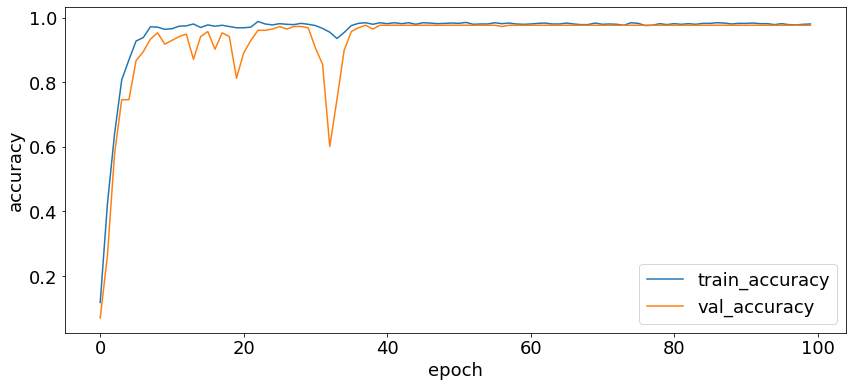

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.rc('font', size=18)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [ ]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *


OUTPUT_VAL_DIR = '../output_val'
OUTPUT_DIR_VAL_TRAIN = os.path.join(OUTPUT_VAL_DIR, 'train')
OUTPUT_DIR_VAL_TEST = os.path.join(OUTPUT_VAL_DIR, 'test')

DATA_AUDIO_VAL_DIR = '../test_val_data'

OUTPUT_DIR_ADJUSTED_VAL_TRAIN = os.path.join(OUTPUT_VAL_DIR, 'adjusted_train')
OUTPUT_DIR_ADJUSTED_VAL_TEST = os.path.join(OUTPUT_VAL_DIR, 'adjusted_test')

DATA_ADJUSTED_AUDIO_VAL_DIR = '../adjusted_val_data'

In [73]:
del_folder(DATA_ADJUSTED_AUDIO_VAL_DIR)
mkdir_p(DATA_ADJUSTED_AUDIO_VAL_DIR)

In [ ]:
del_folder(OUTPUT_DIR_VAL_TRAIN)
del_folder(OUTPUT_DIR_VAL_TEST)
mkdir_p(OUTPUT_DIR_VAL_TRAIN)
mkdir_p(OUTPUT_DIR_VAL_TEST)

In [ ]:
del_folder(OUTPUT_DIR_ADJUSTED_VAL_TRAIN)
del_folder(OUTPUT_DIR_ADJUSTED_VAL_TEST)
mkdir_p(OUTPUT_DIR_ADJUSTED_VAL_TRAIN)
mkdir_p(OUTPUT_DIR_ADJUSTED_VAL_TEST)

In [74]:
PAD_SIZE = 10000
TARGET_SR = 22050
AUDIO_LENGTH = TARGET_SR * 10
SEGMENT_NUM = 2

In [ ]:
def adjusting_noise_val():
     for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        jackhammer = speech_r.AudioFile(wav_filename)
​
        with jackhammer as source:
            r.adjust_for_ambient_noise(source)
            audio = r.record(source)
            
            output_folder = DATA_ADJUSTED_AUDIO_VAL_DIR
            if not os.path.exists(os.path.join(output_folder, wav_filename.split('/')[2])):
                mkdir_p(os.path.join(output_folder, wav_filename.split('/')[2]))
            output_filename = os.path.join(output_folder, wav_filename.split('/')[2], wav_filename.split('/')[3])
            
            fw = open(output_filename, "wb")
            fw.write(audio.get_wav_data())
            fw.close()

In [75]:
def convert_val_data():
    
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_ADJUSTED_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        
        voice_seg = []
        if original_length > AUDIO_LENGTH * SEGMENT_NUM + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            second_seg = audio_buf[AUDIO_LENGTH+PAD_SIZE+1 : PAD_SIZE+AUDIO_LENGTH*2+1]
            
            voice_seg.append(first_seg)
            voice_seg.append(second_seg)
            print(AUDIO_LENGTH,len(first_seg),len(second_seg))
        elif original_length > AUDIO_LENGTH + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            voice_seg.append(first_seg)
            print('Drop 1 Segment, Audio length={}'.format(len(audio_buf)))
        else:
            print('Drop 2 Segment, Audio length={}'.format(len(audio_buf)))
            

        output_folder = OUTPUT_DIR_ADJUSTED_VAL_TRAIN
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_ADJUSTED_VAL_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[19:-4]).replace('/', '_') + '.pkl')
        out_segs = []
        for i_seg, audio_seg in enumerate(voice_seg) :
            out = {'class_id': class_id,
               'audio': audio_seg,
               'sr': TARGET_SR}
            
            with open(str(output_filename+"_"+str(i_seg)), 'wb') as w:
                pickle.dump(out, w)

            print(str(output_filename+"_"+str(i_seg)))
        
        print("-----------------")

if __name__ == '__main__':
    convert_val_data()

0 ../test_val_data/2017019880001_kimsubin/12.wav 448762 -0.0 0.9999999
Drop 1 Segment, Audio length=448762
../output_val/train/17019880001_kimsubin_12.pkl_0
-----------------
1 ../test_val_data/2017019880001_kimsubin/5.wav 479744 0.0 1.0
220500 220500 220500
../output_val/test/17019880001_kimsubin_5.pkl_0
../output_val/test/17019880001_kimsubin_5.pkl_1
-----------------
2 ../test_val_data/2017019880001_kimsubin/4.wav 484864 -0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_4.pkl_0
../output_val/train/17019880001_kimsubin_4.pkl_1
-----------------
3 ../test_val_data/2017019880001_kimsubin/8.wav 471341 0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_8.pkl_0
../output_val/train/17019880001_kimsubin_8.pkl_1
-----------------
4 ../test_val_data/2017019880001_kimsubin/6.wav 494048 -0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_6.pkl_0
../output_val/train/17019880001_kimsubin_6.pkl_1
-----------------
5 ../test_val_data/201701

In [94]:
from sklearn.metrics import accuracy_score

val_files = glob(os.path.join(DATA_ADJUSTED_AUDIO_VAL_DIR, '**.pkl_*'))
val_files.sort()

x_val, y_val = get_data(val_files)
print('y_val : ', y_val)
print(x_val.shape, y_val.shape)
pred_out = model.predict(x_val)

real =[]
pred_out_idex=[]

list_dir = os.listdir(DATA_ADJUSTED_AUDIO_DIR)
list_dir.sort()

j = 0
for i,pred in enumerate(pred_out) :
    if np.argmax(pred) != y_val[i]:
        print('\033[31m'+"Predict :"+str(list_dir[np.argmax(pred)])+" , Real :"+str(list_dir[y_val[i]])+", Likelihood :"+str(np.max(pred)))
    else:
        print('\033[30m'+"Predict :"+str(list_dir[np.argmax(pred)])+" , Real :"+str(list_dir[y_val[i]])+", Likelihood :"+str(np.max(pred)))
    real.append(list_dir.index(list_dir[y_val[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print ('\n\033[30m'+"Final Predict Likelihood : "+format(accuracy_score(real, pred_out_idex)*100, ".4f"))

y_val :  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13 13 13
 13 13 13 13 13 28 28 43 43 43 43 43 43 43 43 43 43 43 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83]
(61, 220500, 1) (61,)
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwakjuheon, Likelihood :0.9950205
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwakjuheon, Likelihood :0.99978393
Predict :2017019770007_simseungmin , Real :2017019740001_kwakjuheon, Likelihood :0.3145155
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9567083
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.97216034
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9904141
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9610421
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9729436
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwa